<a href="https://colab.research.google.com/github/nmningmei/LevelUpPythonTutorial/blob/master/1_30_2_parallelize_simple_for_loop.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
from tqdm import tqdm

In [0]:
np.random.seed(12345)
samples = np.random.exponential(1.5,size = (15,60))

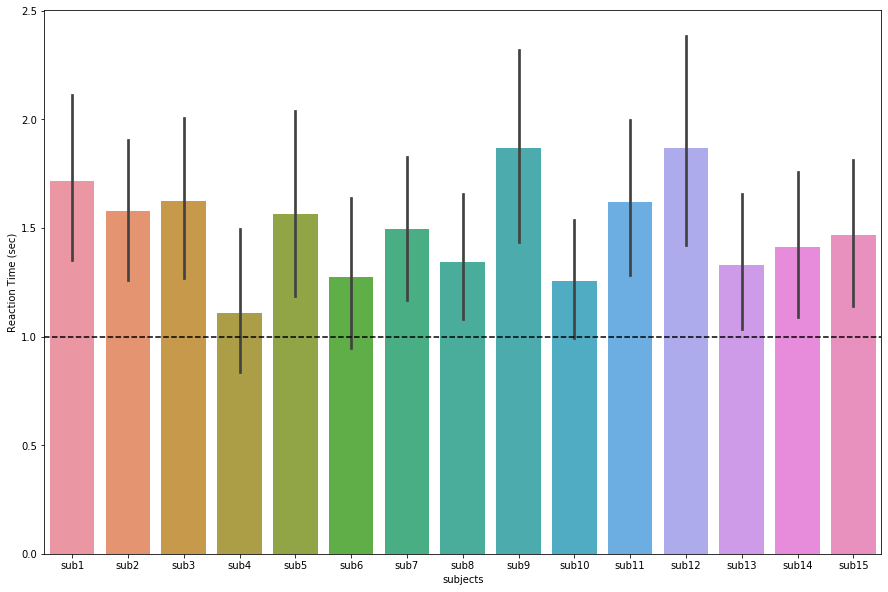

In [0]:
df = pd.DataFrame(samples.T,columns = [f'sub{ii+1}' for ii in range(samples.shape[0])])
df_plot = pd.melt(df,value_vars = df.columns)
fig,ax = plt.subplots(figsize = (15,10))
ax = sns.barplot(x = 'variable',
                 y = 'value',
                 data = df_plot,
                 ax = ax,)
ax.set(xlabel = 'subjects',ylabel = 'Reaction Time (sec)')
ax.axhline(1.,linestyle = '--',color = 'black',)

In [0]:
def resample_ttest(x,baseline = 0.5,n_ps = 100,n_permutation = 10000,one_tail = False,
                   n_jobs = -1, verbose = 0,super_computer = False,):
    """
    http://www.stat.ucla.edu/~rgould/110as02/bshypothesis.pdf
    https://www.tau.ac.il/~saharon/StatisticsSeminar_files/Hypothesis.pdf
    Inputs:
    ----------
    x: numpy array vector, the data that is to be compared
    baseline: the single point that we compare the data with
    n_ps: number of p values we want to estimate
    one_tail: whether to perform one-tailed comparison
    """
    import numpy as np
    # t statistics with the original data distribution
    t_experiment = (np.mean(x) - baseline) / (np.std(x) / np.sqrt(x.shape[0]))
    null            = x - np.mean(x) + baseline # shift the mean to the baseline but keep the distribution
    if super_computer:
        temp = np.random.choice(null,size = (null.shape[0],int(n_permutation),int(n_ps)))
        temp = temp.mean(0)
        ps = (np.sum(temp >= t_experiment,axis = 0) + 1) / (int(n_permutation) + 1)
    else:
        from joblib import Parallel,delayed
        import gc
        gc.collect()
        def t_statistics(null,size,):
            """
            null: shifted data distribution
            size: tuple of 2 integers (n_for_averaging,n_permutation)
            """
            null_dist = np.random.choice(null,size = size,replace = True)
            t_null = (np.mean(null_dist,0) - baseline) / (np.std(null_dist,0) / np.sqrt(null_dist.shape[0]))
            if one_tail:
                return ((np.sum(t_null >= t_experiment)) + 1) / (size[1] + 1)
            else:
                return ((np.sum(np.abs(t_null) >= np.abs(t_experiment))) + 1) / (size[1] + 1) /2
        ps = Parallel(n_jobs = n_jobs,verbose = verbose)(delayed(t_statistics)(**{
                        'null':null,
                        'size':(null.shape[0],int(n_permutation)),}) for i in range(n_ps))
    
    return np.array(ps)

In [0]:
results = dict(sub = [],
               ps_mean = [],
               ps_std = [],
               rt_mean = [],
               rt_std = [],)
for sub,df_sub in tqdm(df_plot.groupby('variable')):
    df_sub
    ps = resample_ttest(df_sub['value'].values,baseline = 1., n_ps = 100,n_permutation = int(1e4),one_tail = True, super_computer=True)
    results['sub'].append(sub)
    results['ps_mean'].append(ps.mean())
    results['ps_std'].append(ps.std())
    results['rt_mean'].append(df_sub['value'].values.mean())
    results['rt_std'].append(df_sub['value'].values.std())
results = pd.DataFrame(results)

100%|██████████| 15/15 [00:07<00:00,  1.95it/s]


In [0]:
results = dict(sub = [],
               ps_mean = [],
               ps_std = [],
               rt_mean = [],
               rt_std = [],)
for sub,df_sub in tqdm(df_plot.groupby('variable')):
    df_sub
    ps = resample_ttest(df_sub['value'].values,baseline = 1., n_ps = 100,n_permutation = int(1e4),one_tail = True, super_computer=False,)
    results['sub'].append(sub)
    results['ps_mean'].append(ps.mean())
    results['ps_std'].append(ps.std())
    results['rt_mean'].append(df_sub['value'].values.mean())
    results['rt_std'].append(df_sub['value'].values.std())
results = pd.DataFrame(results)

100%|██████████| 15/15 [00:11<00:00,  1.34it/s]
